In [1]:
# Running on GPU?
import setGPU

import getpass
import h5py
import pickle
import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm

setGPU: Setting GPU to: 0


In [2]:
import os
import getpass
# Get permission to access EOS (Insert your NICE password)
os.system("echo %s | kinit" % getpass.getpass())

········


0

In [3]:
import json
import numpy as np
import pandas as pd

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Lambda, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.activations import sigmoid, linear, relu
from keras.models import Model, load_model
from keras.regularizers import l1, l2, l1_l2

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [4]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

# Select PD
nPD = 11

In [5]:
legend = [{"name": 'pf_jets', "start": 0, "end": 776},
          {"name": 'cal_jet_mets', "start": 777, "end": 944},
          {"name": 'pho', "start": 945, "end": 1280},
          {"name": 'muons', "start": 1281, "end": 1784},
          {"name": 'pf_jets2', "start": 1785, "end": 1889},
          {"name": 'pf_mets', "start": 1890, "end": 1917},
          {"name": 'nvtx', "start": 1918, "end": 1924},
          {"name": 'cal_jet_mets2', "start": 1925},
          {"name": 'sc', "start": 2037, "end": 2127},
          {"name": 'cc', "start": 2128, "end": 2169},
          {"name": 'pho2', "start": 2170, "end": 2365},
          {"name": 'muons2', "start": 2366, "end": 2491},
          {"name": 'ebs', "start": 2492, "end": 2701},
          {"name": 'hbhef', "start": 2702, "end": 2764},
          {"name": 'presh', "start": 2765, "end": 2806},
          {"name": 'inst_lumi', "start": 2807, "end": 2808}]

In [6]:
data_directory = "/eos/cms/store/user/fsiroky/consistentlumih5/"
label_file = "/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/JetHT.json"
model_directory = "/eos/user/t/tkrzyzek/autoencoder/standard/"
model_name = "model"

In [7]:
def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

files = get_file_list(data_directory, PDs, nPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, nPD, "signal", ".h5")

In [15]:
# Load good and bad jets
def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

data = pd.DataFrame(get_data(files))

Reading: JetHT_C_background
Reading: JetHT_D_background
Reading: JetHT_E_background
Reading: JetHT_F_background
Reading: JetHT_G_background
Reading: JetHT_H_background
Reading: JetHT_C_signal
Reading: JetHT_D_signal
Reading: JetHT_E_signal
Reading: JetHT_F_signal
Reading: JetHT_G_signal
Reading: JetHT_H_signal


In [16]:
data["run"] = data[2807].astype(int)
data["lumi"] = data[2808].astype(int)
data["inst_lumi"] = data[2809].astype(float)

# Drop unnecessary meta data
data.drop([2808, 2809, 2810, 2811, 2812], axis=1, inplace=True)

# Append inst. luminosity at the end as well
data[2807] = data["inst_lumi"]

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

old_data = data

# Reset index
data = data.reset_index(drop=True)  

runIDs  = data["run"].astype(int)
lumiIDs = data["lumi"].astype(int)
luminosity = data["inst_lumi"].astype(float)

In [20]:
old_data = old_data.reset_index(drop=True)

In [27]:
old_data[(old_data['run'] == 282092) & (old_data['lumi'] == 628)]

,0,1,2,3,4,5,6,7,8,9,...,2801,2802,2803,2804,2805,2806,2807,run,lumi,inst_lumi
131021,16.286322,37.716888,5.000101,6.924732,9.414346,13.396825,1173.713013,-0.012418,2.776696,-5.072258,...,1.704304,-3.141454,-1.285342,0.0,1.255322,3.141429,0.211,282092,628,0.211


In [45]:
old_data[(old_data['run'] == 283478) & (old_data['lumi'] == 317)]

,0,1,2,3,4,5,6,7,8,9,...,2801,2802,2803,2804,2805,2806,2807,run,lumi,inst_lumi
151054,18.25511,39.557678,5.000038,7.520359,10.772744,15.890538,2307.516846,-1.034913,2.246245,-5.093869,...,1.675217,-3.141563,-1.222109,0.0,1.223152,3.141397,0.279,283478,317,0.279


In [10]:
# Apply labels
output_json = json.load(open(label_file))

def json_checker(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(output_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

In [11]:
data.shape

(163684, 2812)

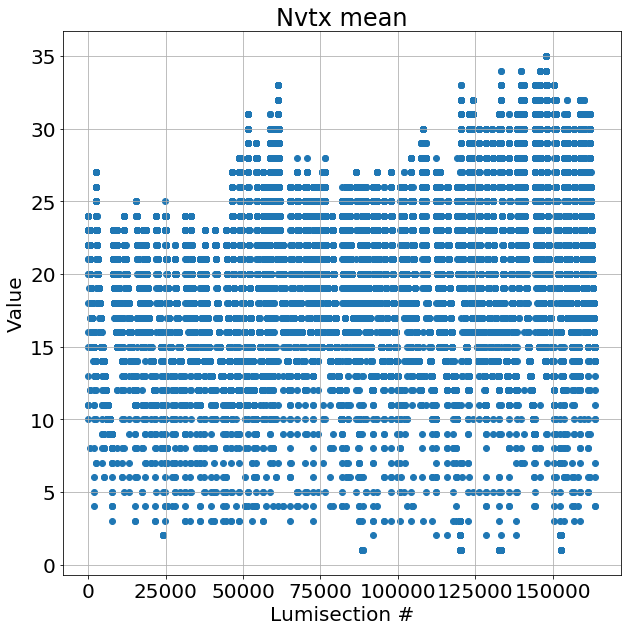

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 32
plt.rcParams.update({'font.size': 20})

plt.scatter(range(len(data.iloc[:, 1918])), data.iloc[:, 1918])
plt.title('Nvtx mean')
plt.xlabel('Lumisection #')
plt.ylabel('Value')
plt.grid()
plt.show()

In [13]:
# Split the data
SPLIT_FACTOR = 0.1

split = round(SPLIT_FACTOR*len(data))

runIDs = runIDs[split:]
lumiIDs = lumiIDs[split:]
luminosity = luminosity[split:]

train = data.iloc[:split]
before = train.shape[0]
X_train = train.iloc[:, 0:2808]
y_train = train["label"]

test = data.iloc[split:]
X_test = test.iloc[:, 0:2808]
y_test = test["label"]

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Train only on good
X_train = X_train[y_train == 0]
X_train_norm = X_train_norm[y_train == 0]

input_dim = X_train.shape[1]

In [82]:
input_layer = Input(shape=(input_dim, ))

x = Dense(2000, kernel_regularizer=l1_l2(10e-5))(input_layer)
x = PReLU()(x)

x = Dense(1000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(500, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(1000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(2000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(input_dim)(x)
x = linear(x)

autoencoder = Model(inputs=input_layer, outputs=x)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2808)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              5618000   
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 2000)              2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 1000)              1000      
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 500)               500       
__________

In [13]:
adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

In [14]:
# X_train = X_train.values
# X_test = X_test.values

In [17]:
autoencoder.fit(X_train_norm,
                X_train_norm,
                epochs=2048,
                batch_size=256,
                validation_split=0.25,
                verbose=2,
                callbacks=[early_stopper, checkpoint_callback])

Train on 11859 samples, validate on 3954 samples
Epoch 1/256
1s - loss: 1.3773 - val_loss: 1.4393
Epoch 2/256
0s - loss: 1.3230 - val_loss: 1.3882
Epoch 3/256
0s - loss: 1.2734 - val_loss: 1.3405
Epoch 4/256
0s - loss: 1.2270 - val_loss: 1.2951
Epoch 5/256
0s - loss: 1.1835 - val_loss: 1.2520
Epoch 6/256
0s - loss: 1.1423 - val_loss: 1.2109
Epoch 7/256
0s - loss: 1.1032 - val_loss: 1.1718
Epoch 8/256
0s - loss: 1.0661 - val_loss: 1.1344
Epoch 9/256
0s - loss: 1.0307 - val_loss: 1.0988
Epoch 10/256
0s - loss: 0.9968 - val_loss: 1.0648
Epoch 11/256
0s - loss: 0.9645 - val_loss: 1.0320
Epoch 12/256
0s - loss: 0.9336 - val_loss: 1.0009
Epoch 13/256
0s - loss: 0.9043 - val_loss: 0.9709
Epoch 14/256
0s - loss: 0.8764 - val_loss: 0.9430
Epoch 15/256
0s - loss: 0.8504 - val_loss: 0.9164
Epoch 16/256
0s - loss: 0.8259 - val_loss: 0.8917
Epoch 17/256
0s - loss: 0.8028 - val_loss: 0.8684
Epoch 18/256
0s - loss: 0.7812 - val_loss: 0.8466
Epoch 19/256
0s - loss: 0.7609 - val_loss: 0.8255
Epoch 20/2

In [18]:
# Reload saved model
autoencoder = load_model("%s%s.h5" % (model_directory, model_name))

In [19]:
# Run predictions
predictions = autoencoder.predict(X_test_norm)

In [20]:
def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.median(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.median(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.median(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)
    
    elif mode == "bottomn":
        temp = np.partition(np.power(X_test - predictions, 2), n_highest)
        result = temp[:,:n_highest]
        return np.median(result, axis=1)

In [24]:
ae_error = get_error_df(X_test_norm, predictions, mode="topn", n_highest=100)

0.851923626199


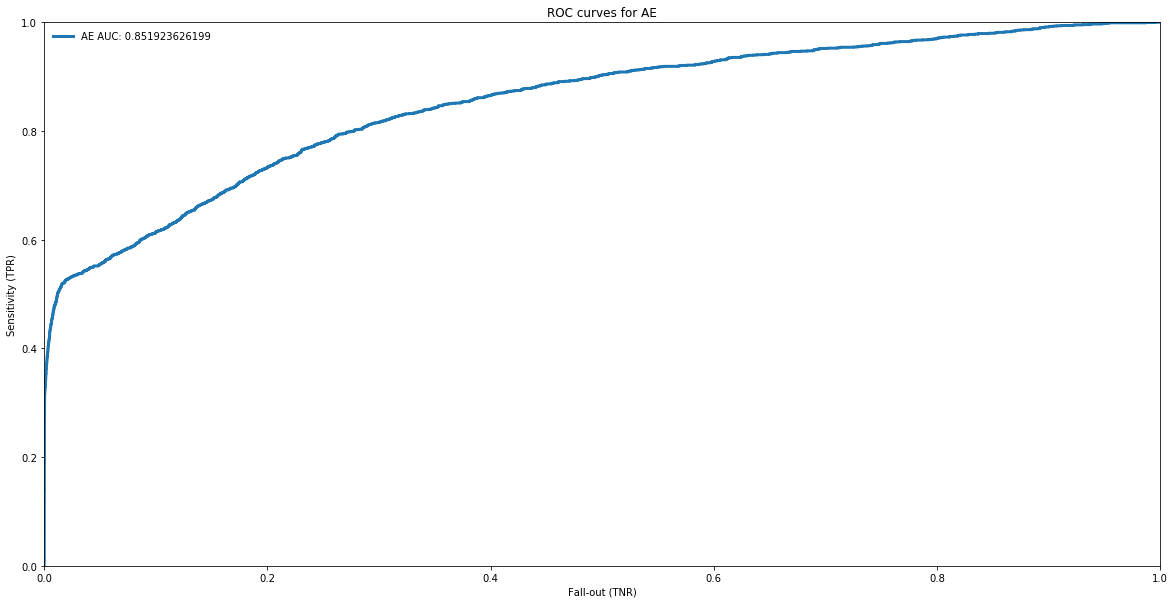

In [25]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve(label, scores, names):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 #linestyle=line_styles[0],
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.title('ROC curves for AE')
    print(roc_auc)
    plt.show()

plt.rcParams['figure.figsize'] = [20, 10]
get_roc_curve(y_test, [ae_error], ['AE'])

In [ ]:
normalized_data = ?

In [28]:
plt.rcParams['figure.figsize'] = [10, 30]
plt_dir = '/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/visualization/features/'
bins = np.linspace(-50, 50, 50)
overlap = []
for i in tqdm(range(2807)):
    v, r = divmod(i, 7)
    
    good_input = normalized_data[normalized_data['label'] == 0].iloc[:, i].values.reshape(-1)
    good_output = ae_pred[y == 0][:, i].reshape(-1)
    filter_fraction = 1
    filtered_idx = (good_input < np.percentile(good_input, 100-filter_fraction))
    filtered_idx &= (good_input > np.percentile(good_input, filter_fraction))
    filtered_idx &= (good_output < np.percentile(good_output, 100-filter_fraction))
    filtered_idx &= (good_output > np.percentile(good_output, filter_fraction))
    good_input_filtered = good_input[filtered_idx]
    good_output_filtered = good_output[filtered_idx]
    
#     print(len(good_input_filtered))
#     print(len(good_input))
    cut = 100 * (1 - len(good_input_filtered) / len(good_input))
#     print(cut)
    overlap_frac = 100 * (4-cut)/2
#     print(overlap_frac)
    overlap.append(overlap_frac)
    
    good_input_orig = data[data['label'] == 0].iloc[:, i].values.reshape(-1)
    filtered_orig_idx = (good_input_orig < np.percentile(good_input_orig, 100-filter_fraction))
    filtered_orig_idx &= (good_input_orig > np.percentile(good_input_orig, filter_fraction))
    good_input_orig_filtered = good_input_orig[filtered_orig_idx]
    
    fig, axes = plt.subplots(3, 1)
    
    axes[0].hist(good_input_orig_filtered, 100, histtype='step', linewidth=2, label="Raw input")
    axes[0].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' raw input histogram')
    axes[0].set_xlabel('Values')
    axes[0].set_ylabel('Number of lumisections')
    axes[0].legend()
    
    axes[1].hist(good_input_filtered, alpha=0.5, histtype='step', linewidth=2, color='b', 
          label="Normalized input")
    axes[1].hist(good_output_filtered, alpha=0.5, histtype='step', linewidth=2, color='r', 
          label="AE output")
    axes[1].set_xlabel('Values')
    axes[1].set_ylabel('Number of lumisections')
    axes[1].legend()
    axes[1].set_title(feature_names[v] + ' ' + var_legend[r]['name'] + ' I/O histogram')
    
    axes[2].hist2d(good_input_filtered, good_output_filtered, norm=LogNorm(), bins=200)
    axes[2].set_title(feature_names[v] + ' ' + var_legend[r]['name'] 
                      + ' input vs output 2d histogram')
    axes[2].set_xlabel('Input values')
    axes[2].set_ylabel('Output values')
    axes[2].axis('equal')
    
    print(plt_dir + str(i) + '_' + feature_names[v] + '_' + var_legend[r]['name'])
#     plt.savefig(plt_dir + str(i) + '_' + feature_names[v] + '_' + var_legend[r]['name'])
    plt.show()
    plt.close()
    print('####################################################################################')

  0%|          | 0/2807 [00:00<?, ?it/s]


NameError: name 'normalized_data' is not defined

In [27]:
pickle.dump(ae_error, open(model_directory + "ae_error.p", "wb"))

In [28]:
pickle.dump(predictions, open(model_directory + "ae_pred.p", "wb"))

In [37]:
pickle.dump(y_test, open(model_directory + "y.p", "wb"))

In [28]:
ae_error = pickle.load(open(model_directory + "ae_error.p", "rb"))
ae_pred = pickle.load(open(model_directory + "ae_pred.p", "rb"))
y = pickle.load(open(model_directory + "y.p", "rb"))

In [29]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)
matplotlib.rcParams["xtick.labelsize"] = 12
matplotlib.rcParams["ytick.labelsize"] = 12
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14
matplotlib.rcParams["axes.titlesize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

In [86]:
legend = [{"name": 'pf_jets', "start": 0, "end": 777, "color": color_palette["Indigo"][100]},
          {"name": 'cal_jet_mets', "start": 778, "end": 946, "color": color_palette["Indigo"][300]},
          {"name": 'pho', "start": 947, "end": 1283, "color": color_palette["Indigo"][500]},
          {"name": 'muons', "start": 1284, "end": 1788, "color": color_palette["Indigo"][700]},
          {"name": 'pf_jets2', "start": 1789, "end": 1894, "color": color_palette["Indigo"][900]},
          {"name": 'pf_mets', "start": 1895, "end": 1923, "color": color_palette["Indigo"][200]},
          {"name": 'nvtx', "start": 1924, "end": 1925, "color": color_palette["Indigo"][400]},
          {"name": 'cal_jet_mets2', "start": 1925, "end": 2037, "color": color_palette["Indigo"][600]},
          {"name": 'sc', "start": 2038, "end": 2129, "color": color_palette["Indigo"][800]},
          {"name": 'cc', "start": 2130, "end": 2172, "color": color_palette["Teal"][100]},
          {"name": 'pho2', "start": 2173, "end": 2369, "color": color_palette["Teal"][300]},
          {"name": 'muons2', "start": 2370, "end": 2476, "color": color_palette["Teal"][500]},
          {"name": 'ebs', "start": 2497, "end": 2707, "color": color_palette["Teal"][700]},
          {"name": 'hbhef', "start": 2708, "end": 2771, "color": color_palette["Teal"][900]},
          {"name": 'presh', "start": 2772, "end": 2808, "color": color_palette["Teal"][400]}]

In [92]:
y = y.reset_index(drop=True)

In [17]:
ae_error.shape

(147316,)

In [18]:
X_test.reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807
0,16.290653,39.103878,5.000079,6.793537,9.134916,13.010658,2178.559326,-0.012259,2.792964,-5.084348,...,2.352735,2.729246,0.004851,1.686092,-3.140562,-1.226298,0.0,1.238480,3.141509,0.192
1,16.091648,37.811668,5.000008,6.779985,9.113189,12.918687,1827.785156,-0.013913,2.793348,-5.084447,...,2.354788,2.729246,-0.015002,1.689484,-3.141450,-1.247423,0.0,1.221913,3.140974,0.192
2,16.335049,38.879379,5.000008,6.780850,9.142194,13.035509,1162.844360,-0.003874,2.791386,-5.079609,...,2.351893,2.729246,-0.008946,1.696844,-3.141502,-1.255995,0.0,1.241628,3.141537,0.192
3,16.271139,38.318874,5.000032,6.776407,9.137701,12.991278,1316.579590,-0.006649,2.793079,-5.083236,...,2.371778,2.729246,-0.014722,1.696905,-3.141010,-1.260419,0.0,1.235353,3.141544,0.191
4,16.204014,38.469170,5.000010,6.765496,9.062444,12.875065,1044.926270,-0.004445,2.791163,-5.095952,...,2.384298,2.724918,-0.004120,1.698909,-3.141230,-1.246195,0.0,1.263445,3.141557,0.191
5,16.205404,37.929966,5.000045,6.773380,9.118381,12.945395,1172.088867,-0.006397,2.790958,-5.066154,...,2.350530,2.729246,-0.014648,1.692102,-3.141553,-1.248856,0.0,1.232776,3.140890,0.192
6,16.233423,38.152927,5.000005,6.771755,9.115519,12.980057,1191.818970,-0.006311,2.791718,-5.081814,...,2.377238,2.729246,-0.006501,1.685168,-3.141385,-1.247852,0.0,1.238963,3.141292,0.191
7,16.182898,37.944763,5.000013,6.777575,9.103284,12.935384,1117.250366,-0.006388,2.792136,-5.088975,...,2.365104,2.727301,0.015579,1.692032,-3.141565,-1.221706,0.0,1.292804,3.141508,0.191
8,16.107071,38.031822,5.000041,6.761449,9.092834,12.895906,1574.433716,-0.007297,2.795467,-5.082069,...,2.353264,2.729246,0.005595,1.678758,-3.141420,-1.214465,0.0,1.239239,3.141414,0.191
9,16.358557,38.765759,5.000008,6.766124,9.117685,12.971684,1179.160522,-0.008385,2.790447,-5.075539,...,2.354401,2.729838,-0.000445,1.697914,-3.141469,-1.245577,0.0,1.267054,3.141283,0.191


In [69]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807
16368,16.290653,39.103878,5.000079,6.793537,9.134916,13.010658,2178.559326,-0.012259,2.792964,-5.084348,...,2.352735,2.729246,0.004851,1.686092,-3.140562,-1.226298,0.0,1.238480,3.141509,0.192
16369,16.091648,37.811668,5.000008,6.779985,9.113189,12.918687,1827.785156,-0.013913,2.793348,-5.084447,...,2.354788,2.729246,-0.015002,1.689484,-3.141450,-1.247423,0.0,1.221913,3.140974,0.192
16370,16.335049,38.879379,5.000008,6.780850,9.142194,13.035509,1162.844360,-0.003874,2.791386,-5.079609,...,2.351893,2.729246,-0.008946,1.696844,-3.141502,-1.255995,0.0,1.241628,3.141537,0.192
16371,16.271139,38.318874,5.000032,6.776407,9.137701,12.991278,1316.579590,-0.006649,2.793079,-5.083236,...,2.371778,2.729246,-0.014722,1.696905,-3.141010,-1.260419,0.0,1.235353,3.141544,0.191
16372,16.204014,38.469170,5.000010,6.765496,9.062444,12.875065,1044.926270,-0.004445,2.791163,-5.095952,...,2.384298,2.724918,-0.004120,1.698909,-3.141230,-1.246195,0.0,1.263445,3.141557,0.191
16373,16.205404,37.929966,5.000045,6.773380,9.118381,12.945395,1172.088867,-0.006397,2.790958,-5.066154,...,2.350530,2.729246,-0.014648,1.692102,-3.141553,-1.248856,0.0,1.232776,3.140890,0.192
16374,16.233423,38.152927,5.000005,6.771755,9.115519,12.980057,1191.818970,-0.006311,2.791718,-5.081814,...,2.377238,2.729246,-0.006501,1.685168,-3.141385,-1.247852,0.0,1.238963,3.141292,0.191
16375,16.182898,37.944763,5.000013,6.777575,9.103284,12.935384,1117.250366,-0.006388,2.792136,-5.088975,...,2.365104,2.727301,0.015579,1.692032,-3.141565,-1.221706,0.0,1.292804,3.141508,0.191
16376,16.107071,38.031822,5.000041,6.761449,9.092834,12.895906,1574.433716,-0.007297,2.795467,-5.082069,...,2.353264,2.729246,0.005595,1.678758,-3.141420,-1.214465,0.0,1.239239,3.141414,0.191
16377,16.358557,38.765759,5.000008,6.766124,9.117685,12.971684,1179.160522,-0.008385,2.790447,-5.075539,...,2.354401,2.729838,-0.000445,1.697914,-3.141469,-1.245577,0.0,1.267054,3.141283,0.191


In [59]:
X_test.iloc[131021 - TRAIN_LEN, :]

0         16.286322
1         37.716888
2          5.000101
3          6.924732
4          9.414346
5         13.396825
6       1173.713013
7         -0.012418
8          2.776696
9         -5.072258
10        -2.321803
11        -0.013256
12         2.267679
13         5.093172
14        -0.004128
15         1.816333
16        -3.141586
17        -1.580600
18        -0.010148
19         1.570869
20         3.141518
21       248.657562
22       144.708252
23        11.816115
24       129.407578
25       243.480026
26       344.874634
27      1173.713013
28        14.227064
29         2.499552
           ...     
2778       2.706184
2779      -0.034108
2780       1.682150
2781      -3.141522
2782      -1.331639
2783       0.000000
2784       1.259506
2785       3.141048
2786       0.004889
2787       0.012876
2788       0.000000
2789       0.000372
2790       0.001604
2791       0.004452
2792       0.235602
2793      -0.067758
2794       2.130893
2795      -2.721633
2796      -2.351593


In [48]:
ae_pred.shape

(147316, 2808)

In [50]:
INDEX - TRAIN_LEN

134686

0


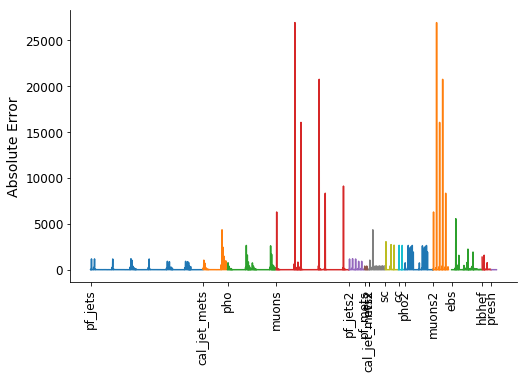

In [99]:
# Choose lumisection
# INDEX = 143601
# INDEX = 120

TRAIN_LEN = 16368

INDEX = 131021 - TRAIN_LEN
# INDEX = 151054 - TRAIN_LEN

print(y[INDEX])

reconstruction = abs(X_test.iloc[INDEX, :] - ae_pred[INDEX ])
features = [i for i in range(ae_error.shape[0])]

for l in legend:
    plt.plot(features[l["start"]:l["end"]],
             reconstruction[l["start"]:l["end"]])

plt.ylabel("Absolute Error")
plt.xticks([l["start"] for l in legend], [l["name"] for l in legend], rotation='vertical')
plt.show();

In [23]:
m_directory = '/afs/cern.ch/user/t/tkrzyzek/Desktop/lumis_example/'

INDEX = 120
# pickle.dump(X_test.iloc[INDEX, :], open(m_directory + "X_test_good.p", "wb"))
# pickle.dump(ae_pred[INDEX], open(m_directory + "ae_pred_good.p", "wb"))
np.save(open(m_directory + "X_test_good.npy", "wb"), X_test.iloc[INDEX, :])
np.save(open(m_directory + "ae_pred_good.npy", "wb"), ae_pred[INDEX])

INDEX = 143601
# pickle.dump(X_test.iloc[INDEX, :], open(m_directory + "X_test_bad.p", "wb"))
# pickle.dump(ae_pred[INDEX], open(m_directory + "ae_pred_bad.p", "wb"))
np.save(open(m_directory + "X_test_bad.npy", "wb"), X_test.iloc[INDEX, :])
np.save(open(m_directory + "ae_pred_bad.npy", "wb"), ae_pred[INDEX])

In [51]:
X_test.iloc[INDEX, :] - ae_pred[INDEX]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
16368,16.290653,39.103878,5.000079,6.793537,9.134916,13.010658,2178.559326,-0.012259,2.792964,-5.084348,...,4.985958,0.069231,3.013229,-5.016519,-2.592928,0.115582,2.853663,5.021555,-0.024545,3.152780
16369,16.091648,37.811668,5.000008,6.779985,9.113189,12.918687,1827.785156,-0.013913,2.793348,-5.084447,...,4.981858,-0.034118,2.973031,-4.975023,-2.756012,-0.041510,2.660723,5.010091,0.003181,3.087678
16370,16.335049,38.879379,5.000008,6.780850,9.142194,13.035509,1162.844360,-0.003874,2.791386,-5.079609,...,4.976280,-0.038091,3.019296,-5.018426,-2.853533,-0.088003,2.748812,4.988570,-0.025833,3.077001
16371,16.271139,38.318874,5.000032,6.776407,9.137701,12.991278,1316.579590,-0.006649,2.793079,-5.083236,...,4.996243,-0.075782,2.997101,-5.008666,-2.853997,-0.108060,2.551271,5.039563,0.026422,3.140505
16372,16.204014,38.469170,5.000010,6.765496,9.062444,12.875065,1044.926270,-0.004445,2.791163,-5.095952,...,5.013932,-0.031125,2.990531,-5.035804,-2.701636,-0.139604,2.735240,5.000010,-0.009866,3.155647
16373,16.205404,37.929966,5.000045,6.773380,9.118381,12.945395,1172.088867,-0.006397,2.790958,-5.066154,...,5.008856,0.062982,3.009114,-5.002280,-2.671645,0.027642,2.824018,5.047811,0.053303,3.142959
16374,16.233423,38.152927,5.000005,6.771755,9.115519,12.980057,1191.818970,-0.006311,2.791718,-5.081814,...,5.000891,-0.014428,3.007897,-5.021437,-2.831513,-0.016345,2.778377,5.011769,0.033484,3.157616
16375,16.182898,37.944763,5.000013,6.777575,9.103284,12.935384,1117.250366,-0.006388,2.792136,-5.088975,...,4.950490,-0.013081,2.989594,-5.019145,-2.725528,-0.027242,2.771619,5.026984,-0.018188,3.132243
16376,16.107071,38.031822,5.000041,6.761449,9.092834,12.895906,1574.433716,-0.007297,2.795467,-5.082069,...,5.014160,0.064554,2.998575,-4.996775,-2.621208,0.091339,2.820930,5.027680,0.024952,3.184685
16377,16.358557,38.765759,5.000008,6.766124,9.117685,12.971684,1179.160522,-0.008385,2.790447,-5.075539,...,5.015633,-0.010513,3.006432,-5.023825,-2.793985,-0.006894,2.776645,4.996935,0.014603,3.121641


In [30]:
def pred_vs_feature2(y_val, x_val, y_class, y_name="", x_name="", selected=[], linear=False,
                    x_lim=None, y_lim=None, title=""):

    fig, (ax1) = plt.subplots(1, 1, sharex=True)
    
    ax = [ax1]
    ax1.set_title(title)
    
    for i in range(1):
        df = pd.DataFrame({'y_val': y_val[i],
                           'x_val': x_val,
                           'y_class': y_class})

        groups = df.groupby('y_class')

        for name, group in groups:
            ax[i].plot(group.x_val, 
                    group.y_val,
                    color="r" if name == 1 else "g",
                    marker='o',
                    ms=2,
                    linestyle='',
                    label= "Bad" if name == 1 else "Good")

        for i in selected:
            ax[i].plot(x_val[i],
                    y_val[i],
                    color="g",
                    marker='o',
                    ms=4,
                    linestyle='')

        ax[i].legend()
        if not linear:
            ax[i].set_yscale('log')
        if x_lim:
            ax[i].set_xlim(x_lim[0], x_lim[1])
        if y_lim:
            ax[i].set_ylim(y_lim[0], y_lim[1])
        ax[i].set_ylabel(y_name[i])
        ax[i].grid()
    plt.xlabel(x_name)
   
    plt.show()

In [31]:
def plot_var(legend, ae_pred):
    for var in legend:
            print("###########################################################################")
            print(var['name'])
            print("###########################################################################")

            X_var = X[:, var['start'] : var['end']+1]
            ae_pred_var = ae_pred[:, var['start'] : var['end']+1]

            mean = np.mean(X_var, axis=1)
            mean_abs = np.mean(np.abs(X_var), axis=1)
            sd = np.std(X_var, axis=1)
            
            ae_mean = np.mean(ae_pred_var, axis=1)
            ae_mean_abs = np.mean(np.abs(ae_pred_var), axis=1)
            ae_sd = np.std(ae_pred_var, axis=1)

            # No scale set
            pred_vs_feature2([mean, mean_abs, sd],
                            luminosity, 
                            y_test, #!!!
                            [var['name'], 
                             var['name'] + " abs"],
                            "Luminosity",
                            title=var['name'],
                            x_lim=(0, 0.35),
#                             y_lim=(-5, 5),
                            linear=True)
            
            pred_vs_feature2([ae_mean, ae_mean_abs, ae_sd],
                            luminosity, 
                            y_test, #!!!
                            [var['name'], 
                             var['name'] + " AE pred"],
                            "Luminosity",
                            title=var['name'] + " AE pred",
                            x_lim=(0, 0.35),
#                             y_lim=(-5, 5),
                            linear=True)
            
            # With bounds [-5, 5]
            pred_vs_feature2([mean, mean_abs, sd],
                            luminosity, 
                            y_test, #!!!
                            [var['name'], 
                             var['name'] + " abs"],
                            "Luminosity",
                            title=var['name'],
                            x_lim=(0, 0.35),
                            y_lim=(-5, 5),
                            linear=True)
            
            pred_vs_feature2([ae_mean, ae_mean_abs, ae_sd],
                            luminosity, 
                            y_test, #!!!
                            [var['name'], 
                             var['name'] + " AE pred"],
                            "Luminosity",
                            title=var['name'] + " AE pred",
                            x_lim=(0, 0.35),
                            y_lim=(-5, 5),
                            linear=True)


In [32]:
# start_legend = 1918 #nvtx
start_legend = 1414

In [33]:
var_legend = [{'start': start_legend, 'end': start_legend, 'name': 'Mean'},
              {'start': start_legend+1, 'end': start_legend+1, 'name': 'RMS'},
              {'start': start_legend+2, 'end': start_legend+2, 'name': 'Q1'},
              {'start': start_legend+3, 'end': start_legend+3, 'name': 'Q2'},
              {'start': start_legend+4, 'end': start_legend+4, 'name': 'Q3'},
              {'start': start_legend+5, 'end': start_legend+5, 'name': 'Q4'},
              {'start': start_legend+6, 'end': start_legend+6, 'name': 'Q5'}]

In [34]:
X = X_test

In [38]:
X = X.values

###########################################################################
Mean
###########################################################################


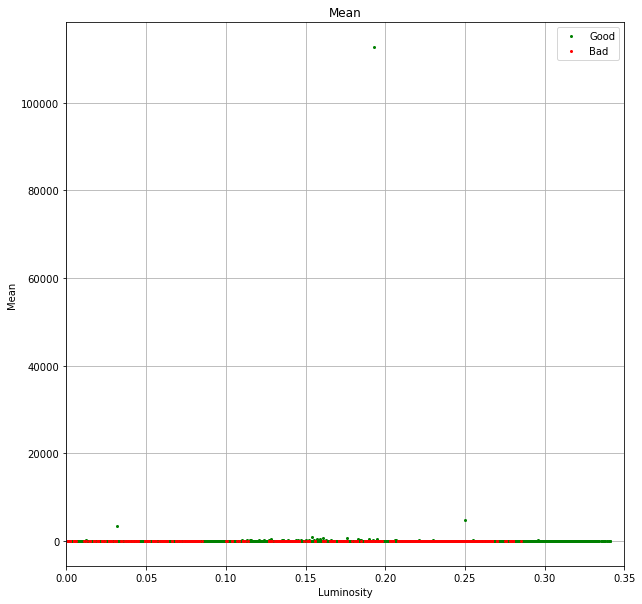

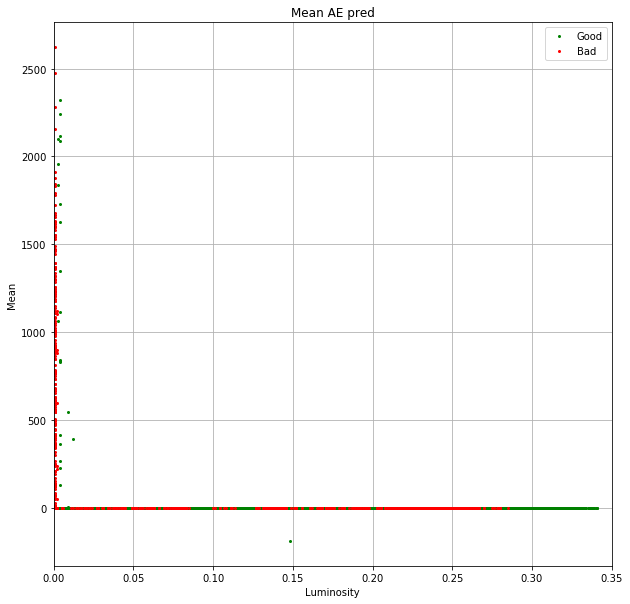

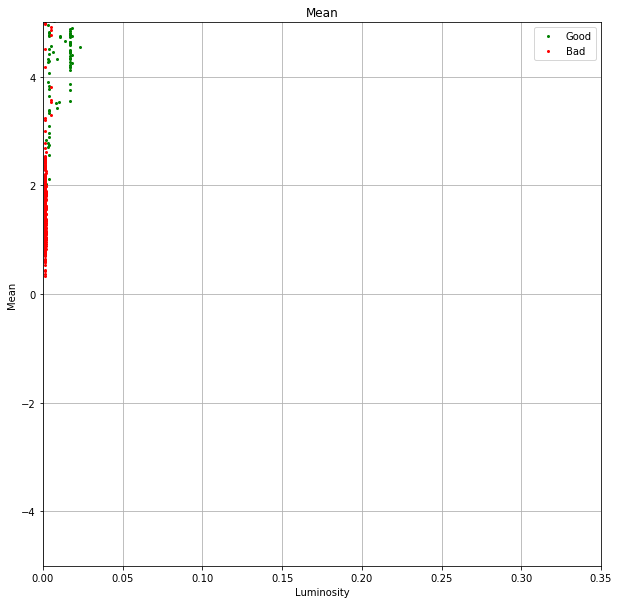

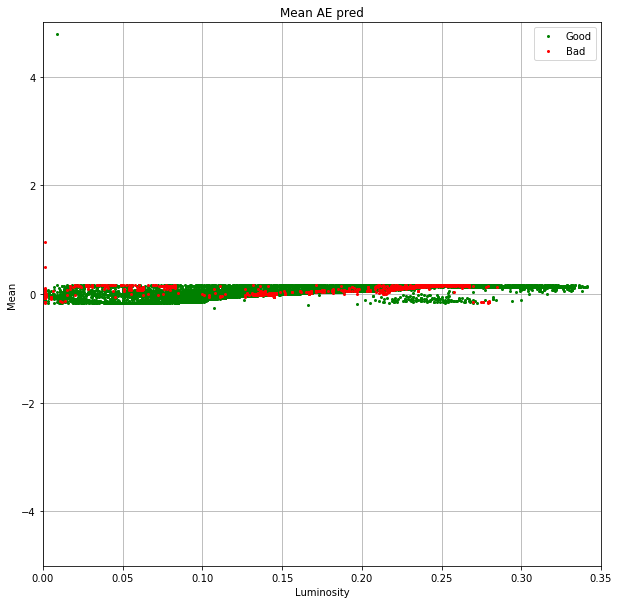

###########################################################################
RMS
###########################################################################


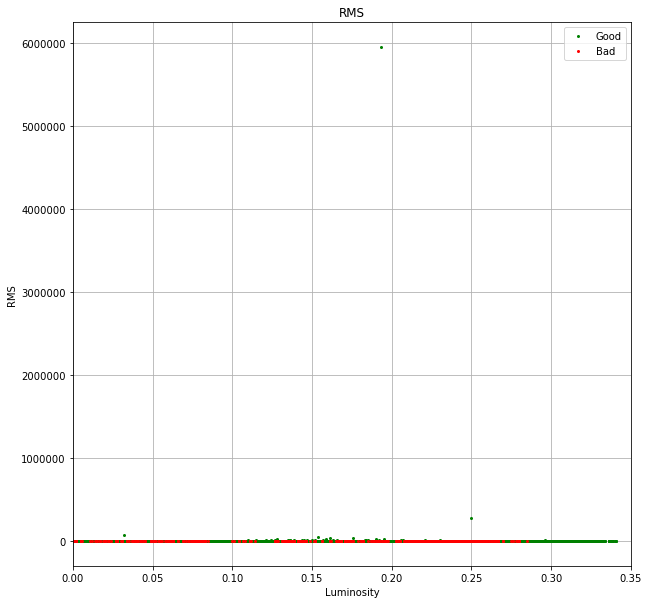

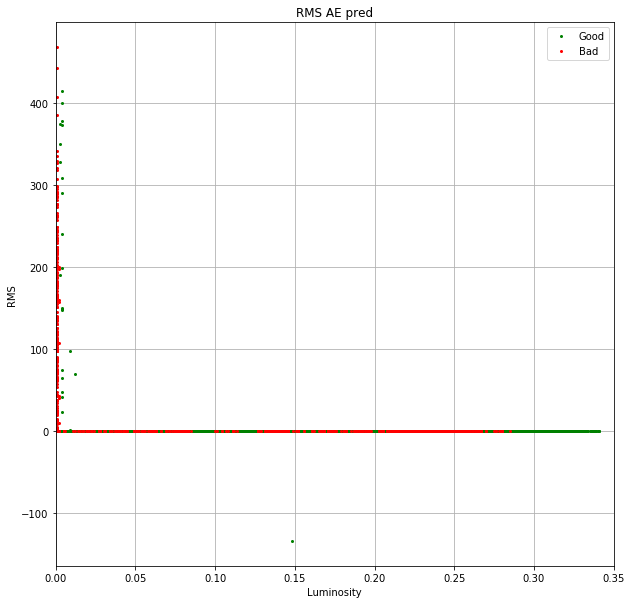

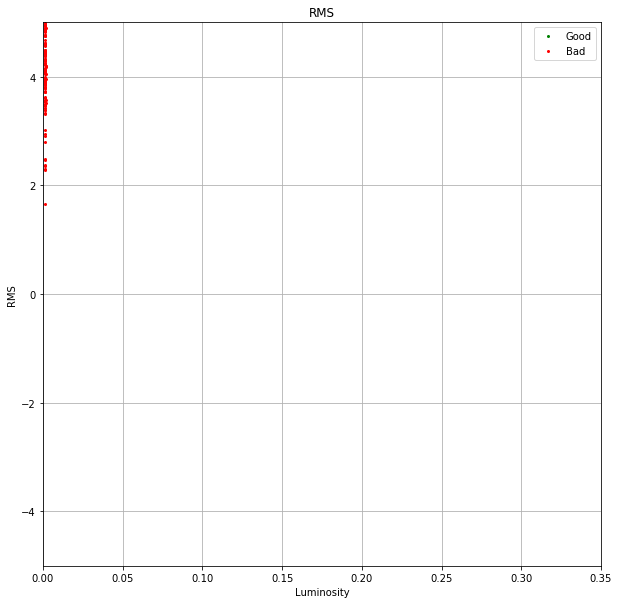

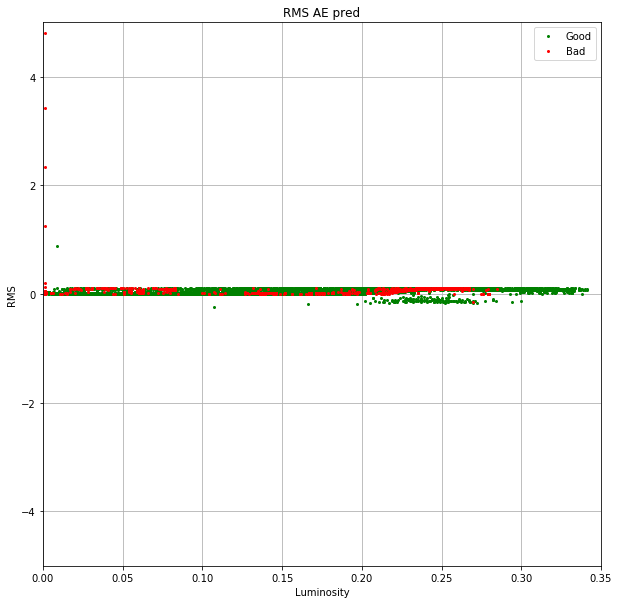

###########################################################################
Q1
###########################################################################


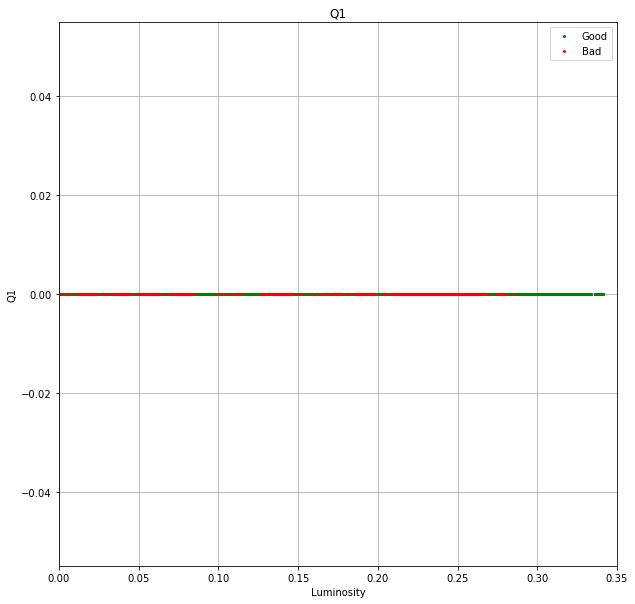

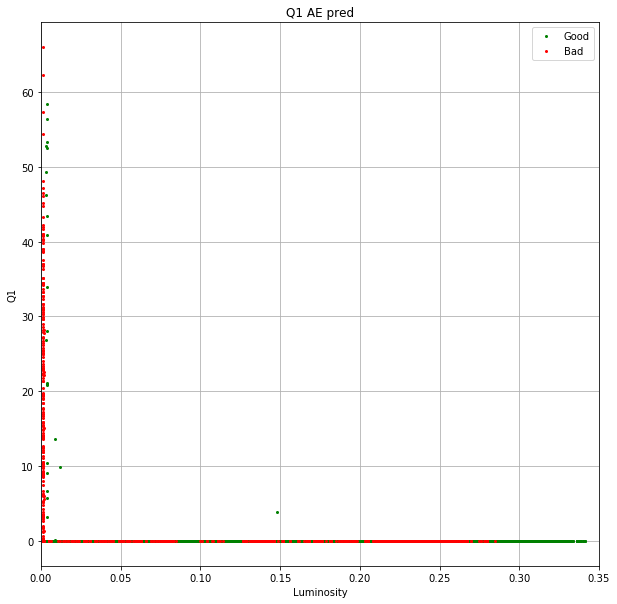

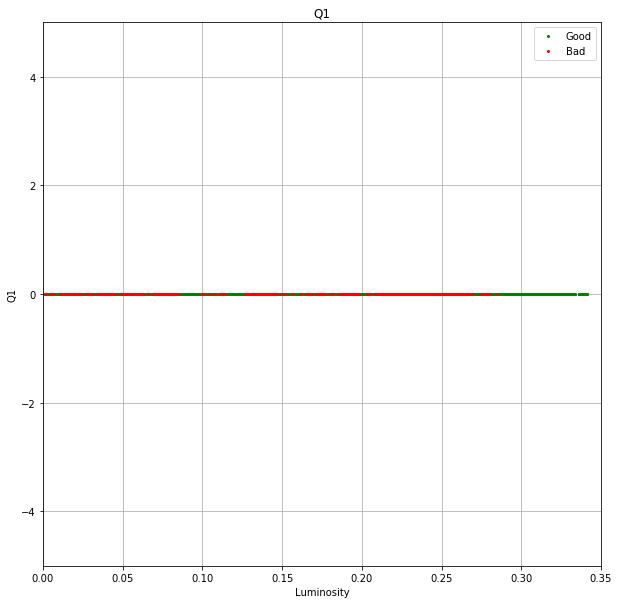

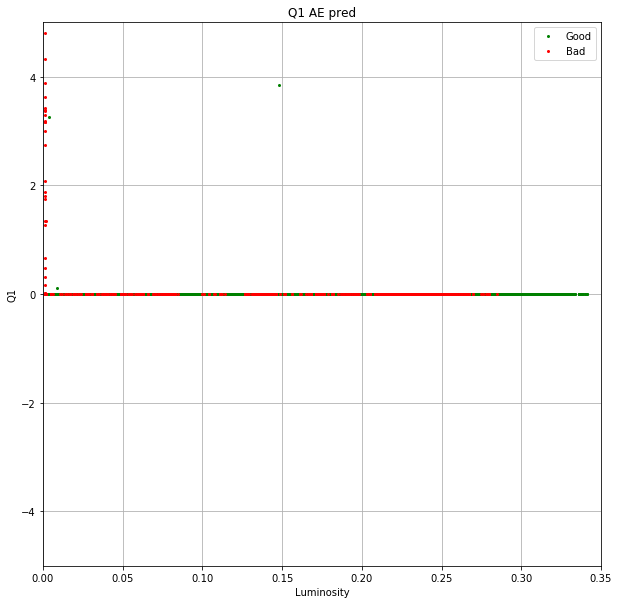

###########################################################################
Q2
###########################################################################


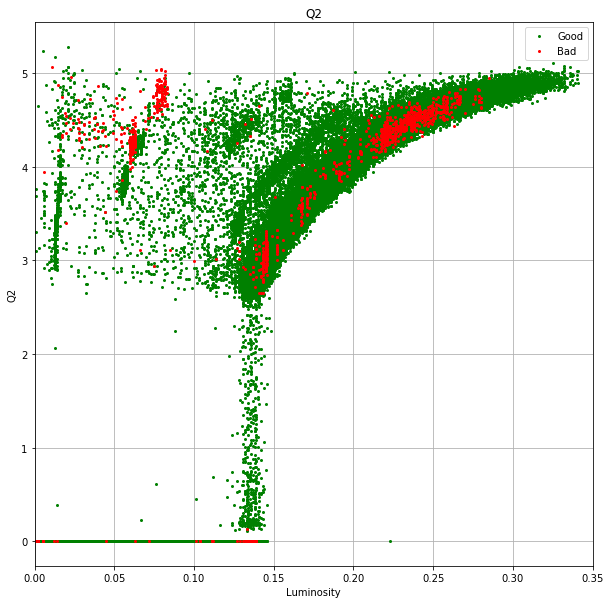

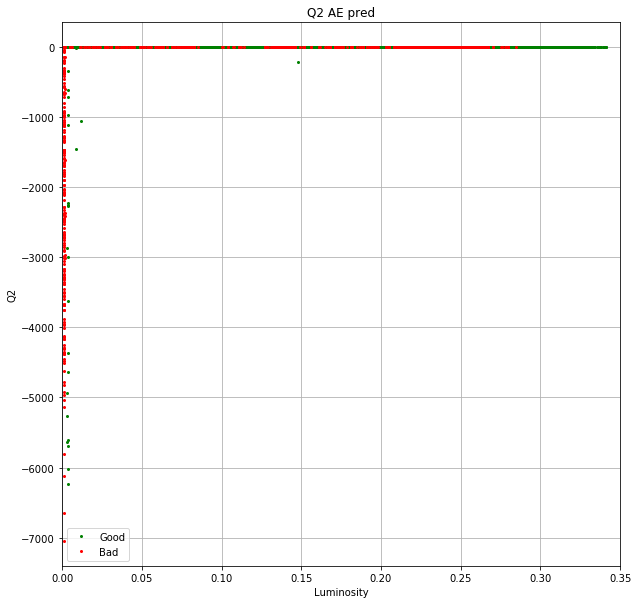

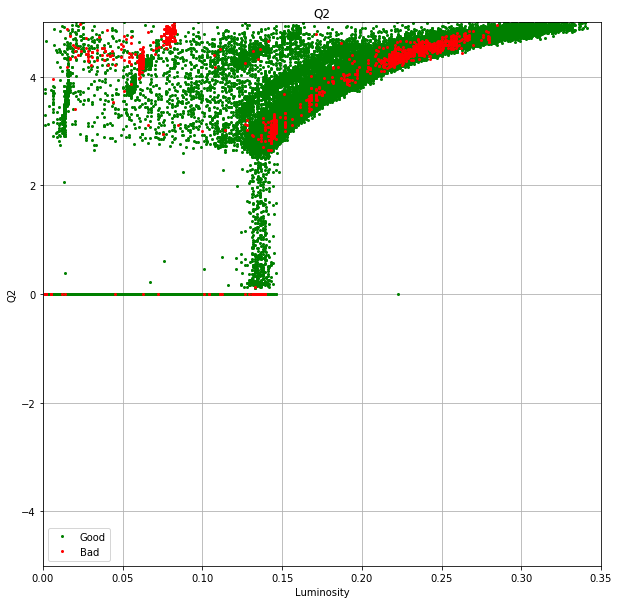

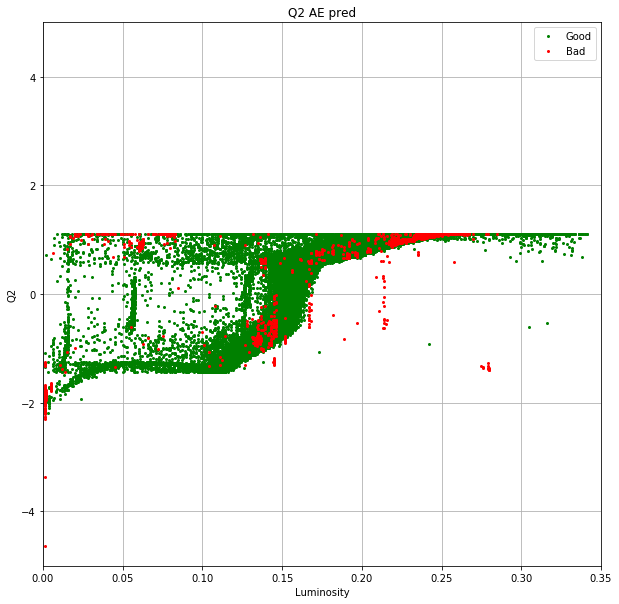

###########################################################################
Q3
###########################################################################


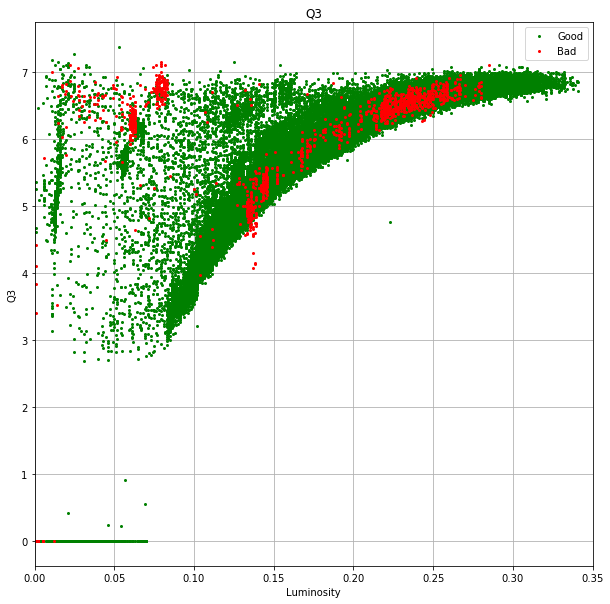

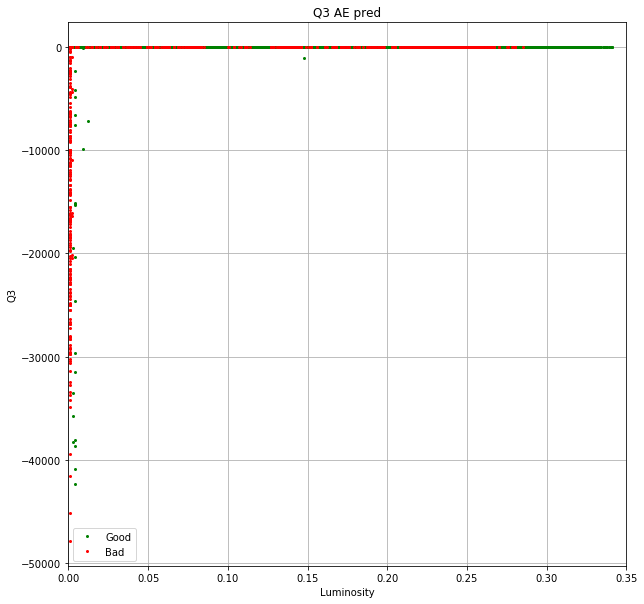

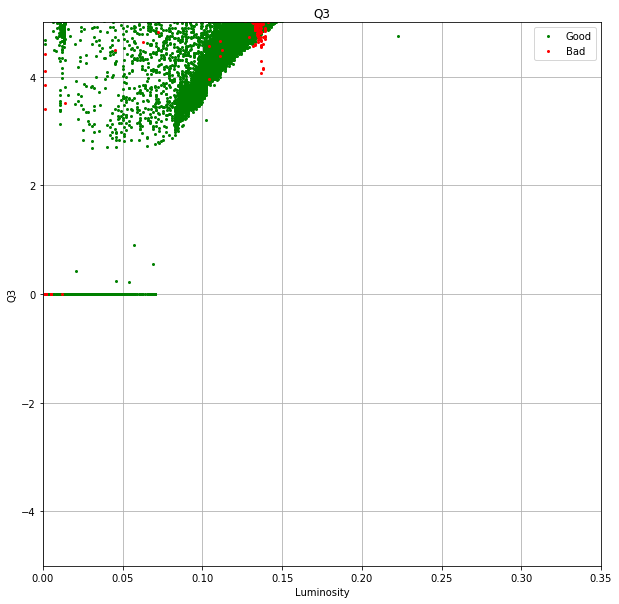

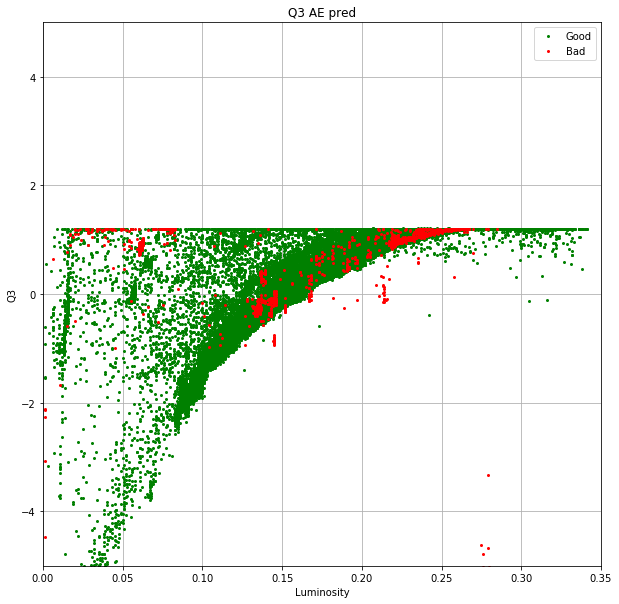

###########################################################################
Q4
###########################################################################


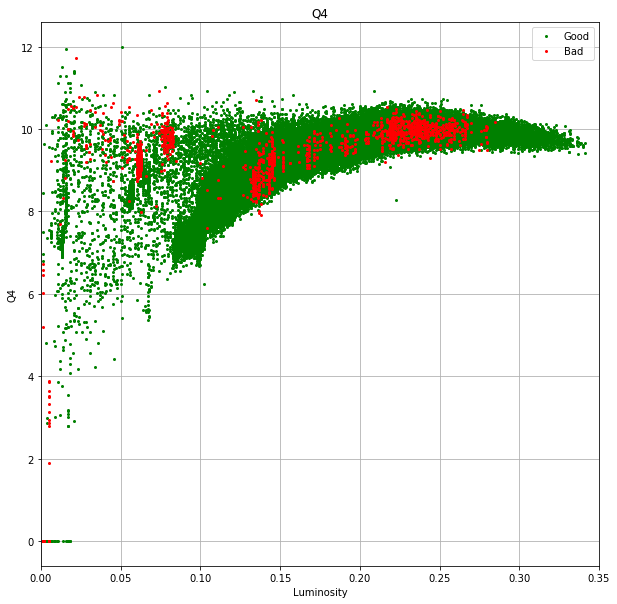

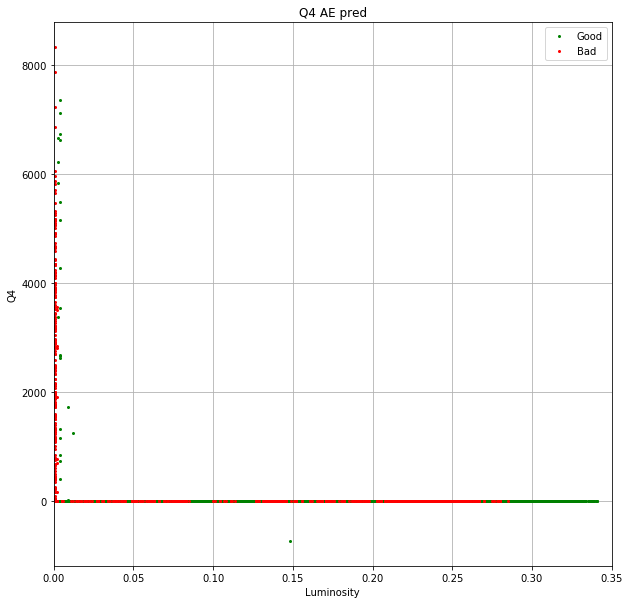

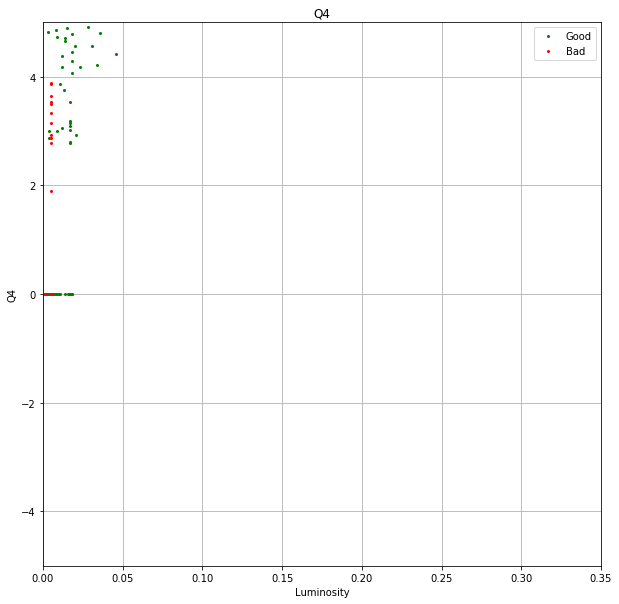

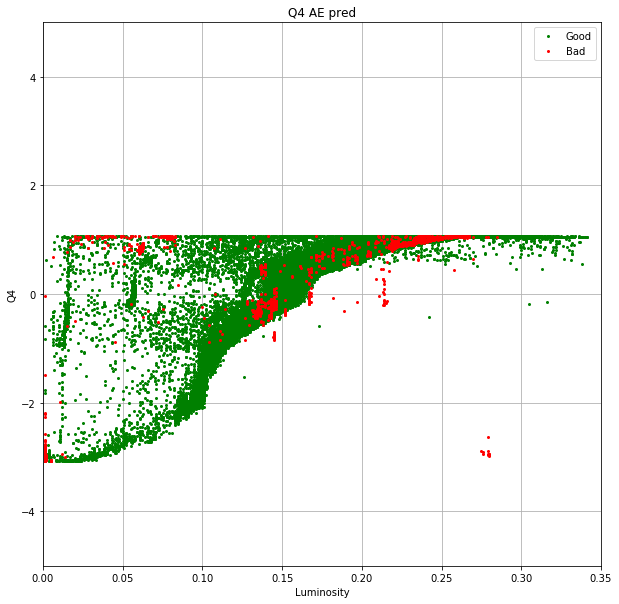

###########################################################################
Q5
###########################################################################


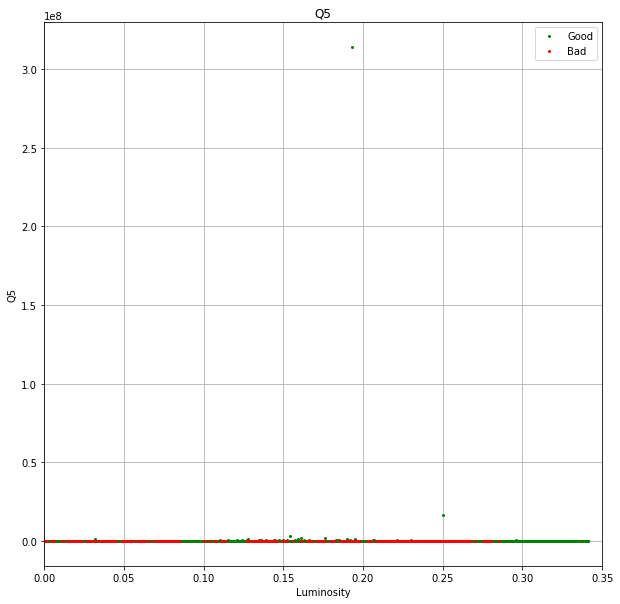

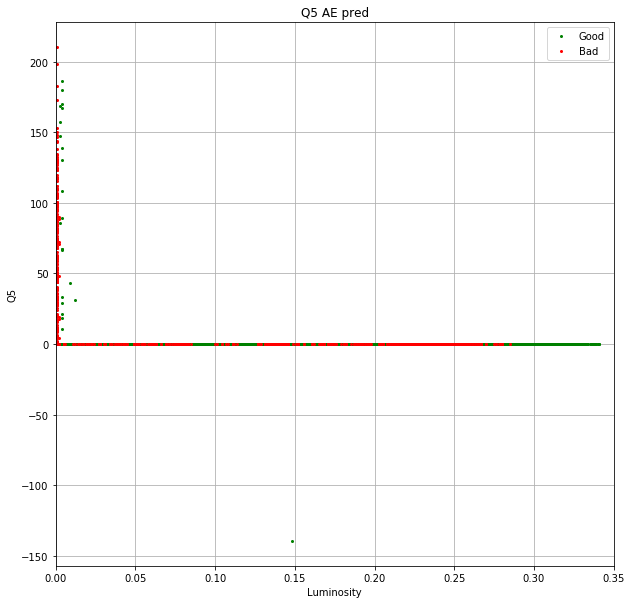

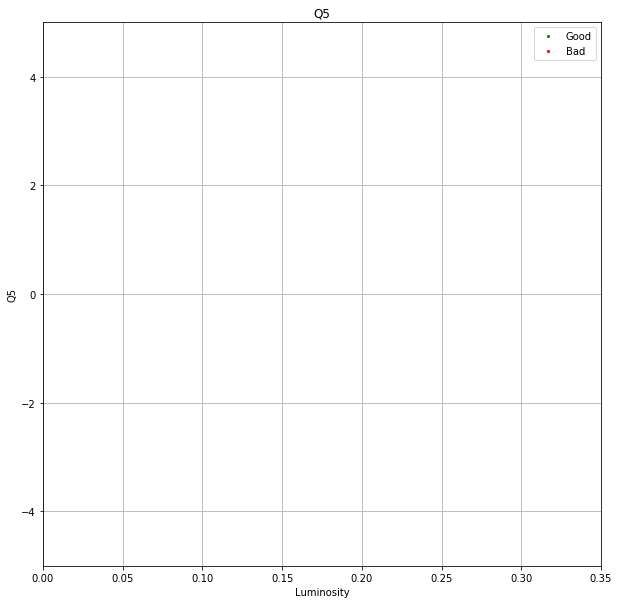

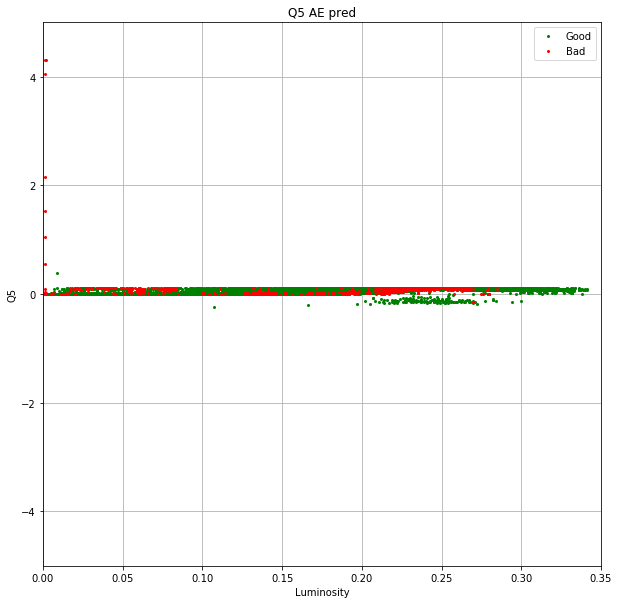

In [39]:
matplotlib.rcParams["figure.figsize"] = (10, 10)
plot_var(var_legend, predictions)